<a href="https://colab.research.google.com/github/joshgregory42/practical_deep_learning/blob/main/ch_05_pet_breeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification

To make our models work, and work reliably, there are a lot of details we need to know.

We need to be able to look inside our neural network as it trains, and as it makes predictions, find possible problems, and know how to fix them.

Some questions/topics we'll answer/cover:

* What is the architecture of a computer vision model?
* What is the architecture of an NLP model, etc.
* How do you create an architecture that matches the needs of your particular domain?


We'll need to know some topics like different types of layers, regularization methods, optimizers, how to put layers together into architectures, labeling techniques, etc.

  * Will cover these on an as-needed basis, won't just dump them all at once.


## From Dogs and Cats to Pet Breeds

In [1]:
from fastai.vision.all import *

path = untar_data(URLs.PETS)

To understand how to get each breed, we need to know how the data are laid out.

Data usually comes as two kinds:

1. Individual files in folders with filenames that tell us what tf are inside of them.
2. Table of data, like a CSV file. This might have the filename of each file and how it connects to other data, like text documents and images.

In [2]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [3]:
# Annotations just tell us where the pets are from, so we'll find that.

(path/'images').ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_149.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_82.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pug_77.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_99.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_98.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_111.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_159.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_56.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_35.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_65.jpg')...]

Note that many functions in `fastai` that return a collection use a class called `L`. Can think of `L` as an enhanced version of the ordinary Python `list` type.

In [4]:
# Pick a filename to test our code:

fname = (path/'images').ls()[0]

fname

Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_149.jpg')

In [5]:
# Write a regex to extract information from the filename/path:

re.findall(r'(.+)_\d+.jpg$', fname.name)

['basset_hound']

That regex takes out all the characters leading up to the last underscore character (as long as the subsequence characters are numerical digits), and then the JPEG file extension.

We know that regexes work for our example, we should scale this up to the whole dataset.

fastai has a lot of classes to help with labeling. For regexes, can use the `RegexLabeller` class via the data block API:

In [6]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))

dls = pets.dataloaders(path/"images")

New blocks:

```python
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75)

```

These lines *presizes* the data. It minimizes data destruction while maintaining good performance. Makes all of our images the same size so that we can pass them efficiently to the GPU.



# Checking and Debugging a DataBlock

Before training a model, should always check your data.

Can do this in a DataBlock by using the `show_batch` method:

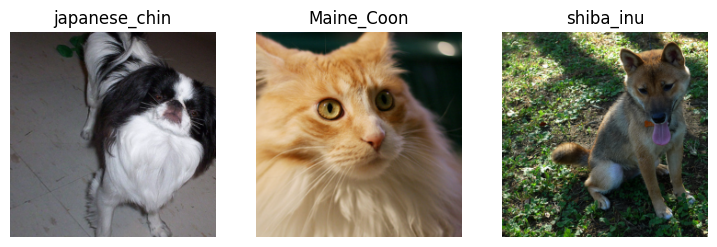

In [7]:
dls.show_batch(nrows=1, ncols=3)

In [8]:
# Can use the summary method to debug:

# Example where we forget to use a Resize transform:

# pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
#                  get_items=get_image_files,
#                  splitter=RandomSplitter(seed=42),
#                  get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
# pets1.summary(path/"images")

Once our data look right, typically want to use it to train a simple model.

We want to know if our problem needs domain-specific engineering (or not), or if the data trains the model in the first place.

* We want to know these things ASAP, which is why we train a simple model to get an idea of what's going on.

In [9]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 72.5MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.526453,0.319481,0.097429,01:37


epoch,train_loss,valid_loss,error_rate,time
0,0.504650,0.290283,0.092016,01:34
1,0.333778,0.216272,0.069689,01:35


We didn't give fastai a loss function, but it's still working, what the fuck?

If you don't provide a loss function, fastai defaults to using cross-entropy loss.

# Cross-Entropy Loss

Is a function that has two main benefits:

* Works even when our dependent variable has more than two categories.
* Results in faster and more reliable training.

# Viewing Activations and Labels

In [10]:
# View activations of our model

# First need to get a batch of real data from our DataLoaders:

x, y = dls.one_batch()

In [11]:
# Display our dependent variable

y

TensorCategory([ 5,  4, 32,  3,  2, 27,  3,  2, 21, 22, 11, 20, 14, 11, 36,  8,
                12, 17, 21, 18, 24,  5, 12, 32, 36, 17, 22, 21, 22, 24, 36,  4,
                35, 32, 19, 29, 33, 32, 36, 21, 19, 30, 14, 17, 18,  4, 14,  5,
                20, 24, 35,  5, 36, 25,  7, 12, 21,  7, 30, 28, 26, 22, 23, 11],
               device='cuda:0')

In [12]:
# Look at predictions using Learner.get_preds

# Returns predictions and targets, but we already have targets,
# so ignore it by assigning them to the special variable _:

preds, _ = learn.get_preds(dl=[(x, y)])

preds[0]

tensor([5.2852e-08, 2.8332e-03, 6.4811e-08, 3.0016e-07, 8.2211e-06, 9.9715e-01,
        3.9616e-07, 1.2326e-07, 9.4743e-09, 1.6695e-06, 2.6941e-07, 3.7108e-07,
        9.1227e-08, 1.8035e-07, 5.7158e-08, 6.6493e-08, 3.4393e-07, 3.9407e-08,
        1.1866e-08, 1.2889e-06, 5.8929e-06, 4.0396e-08, 7.6338e-09, 3.5021e-08,
        1.0504e-08, 5.7821e-09, 1.5321e-07, 9.7768e-08, 1.6649e-08, 2.0756e-07,
        9.7551e-09, 2.2432e-08, 7.8373e-09, 1.0000e-08, 2.3603e-08, 6.2542e-08,
        2.3192e-08])

This returns the predictions that are 37 probabilities (total number of breeds) between 0 and 1 for each breed.

So this is a set of probabilities for each breed that we have, given a sample image.

In [13]:
len(preds[0]), preds[0].sum()

(37, tensor(1.0000))

If we have more categories in our target (like 37 pet breeds), we'll need more activations

Example is a NN that predicts 3s and 7s and returns two activations, one for each class.

Use some random numbers with a standard deviation of 2, assuming we have 6 images and 2 possible categories (first is 3s, and the second is 7s).

In [14]:
acts = torch.randn((6, 2))*2

acts

tensor([[-0.9916, -2.2545],
        [ 0.1560, -1.9368],
        [-0.6164,  1.1047],
        [-2.0798, -2.1778],
        [ 1.6429, -3.7728],
        [-1.2445, -2.9512]])

Can't take the sigmoid of this directly since the rows don't add up to 1.

Really, all we care about here for a binary case is the relative difference between the two activations, so let's just subtract them. This is because a single pair of activations indicates the relative confidence of the input being a 3 vs a 7.

In [15]:
(acts[:, 0] - acts[:, 1]).sigmoid()

tensor([0.7795, 0.8902, 0.1517, 0.5245, 0.9956, 0.8464])

The `softmax` function does this that works for more than two columns.

Put simply: `softmax` is the multi-category equivalent of `sigmoid`.

Use it whenever we have more than 2 categories and the probabilities of the categories need to add to 1.

Softmax is the first part of the cross-entropy loss -- the second part is log likelihood.

## Log Likelihood

We need to extend the loss function to work with more than just binary classification.

For our synthetic 3/7 example, let's say that these are out labels:

In [16]:
targ = tensor([0, 1, 0, 1, 1, 0])

In [17]:
# Softmax activations:

sm_acts = tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])



In [18]:
idx = range(6)

sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [19]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [20]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

nll in `nll_loss` stands for "negative log likelihood", but assumes that you have already taken the log. Want to use `nll_loss` after you've used `log_softmax`, which takes the softmax and then the log.

Want to use a logarithm because it can be stored easily on computers, but also easily detects differences between small numbers.

Logs can also replace multiplication (which can create huge or really small numbers) with addition, which is easier for computers to handle.

Another benefit to using the log for the loss is that our loss function penalizes predictions that are both confident and wrong, which works well in practice to aid in more effective model training.

## Negative Log Likelihood

Take the mean of the negative log of our probabilities. So taking the mean of the `loss` column of our table gives us the *negative log likelihood loss*, which is another name for cross-entropy loss.

What we're doing is taking the softmax, then the log likelihood of that.

Available in `nn.CrossEntropyLoss`, which calls `log_softmax` and then `nll_loss`:

In [21]:
loss_func = nn.CrossEntropyLoss()

Since `CrossEntropyLoss` is a class, when we instantiate it we have an object that behaves like a function:

In [22]:
loss_func(acts, targ)

tensor(1.7790)

Can also access this from the `F` namespace:

In [23]:
F.cross_entropy(acts, targ)

tensor(1.7790)

# Model Interpretation

* Loss functions are hard to interpret because they're designed to be numbers that computers differentiate and optimize.
* The human-readable aspect is a metric.

A famous metric is the confusion matrix:

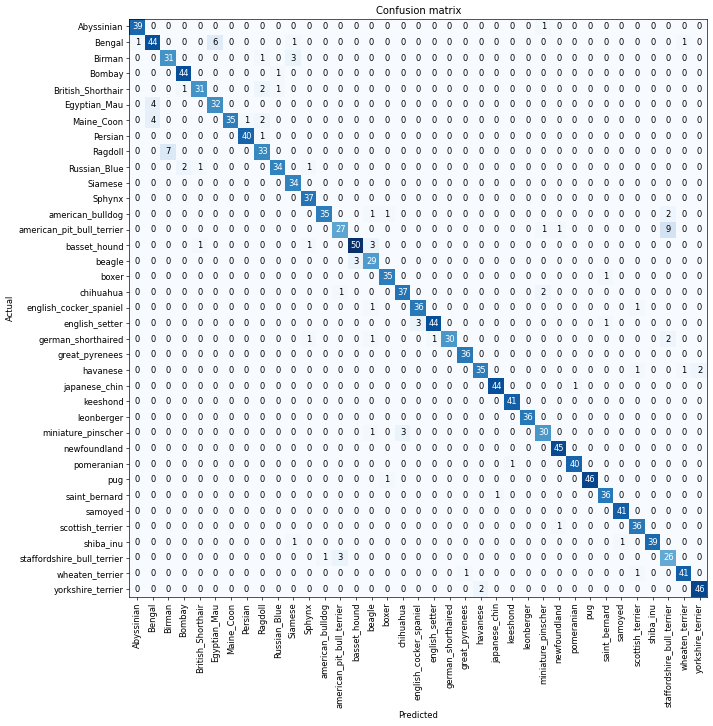

In [24]:
# width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


In [25]:
# That sucks to read, so just use the most_confused method:

interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 9),
 ('Ragdoll', 'Birman', 7),
 ('Bengal', 'Egyptian_Mau', 6)]

# Improving Our Model

First thing we need to set when training a model is the learning rate.

fastai can help in finding the right learning rate.

## The Learning Rate Finder

We know that if we have a low learning rate, our model will take forever to train and might overfit. So higher is better right?

Let's just see what happens if we make our learning rate really high:

In [26]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.699839,6.578214,0.559540,01:32


epoch,train_loss,valid_loss,error_rate,time
0,3.516022,2.020725,0.568336,01:35


Well that's pretty bad. Basically just had the optimizer overshoot when it stepped in the correct direction, and then it over-corrected, so just kept bouncing around.

Solution: The *learning rate finder*:

1. Start with a really small learning rate, use that for one mini-batch. Find the losses and increase the learning rate by some percentage (i.e. double it).
2. Do another mini-batch, track the loss, double the learning rate again.
3. Keep do this until the loss gets worse instead of better.
4. That point is where we went too far. Pick a learning rate that's slightly lower than this point, usually either:
  * One order of magnitude less than where the minimum loss was achieved (i.e., the minimum divided by 10)
  * The last point where the loss was clearly decreasing.


The learning rate finder computes this for you. Both those rules usually gives you roughly the same number.

If you don't specify one, the fastai library uses a default (1e-3):

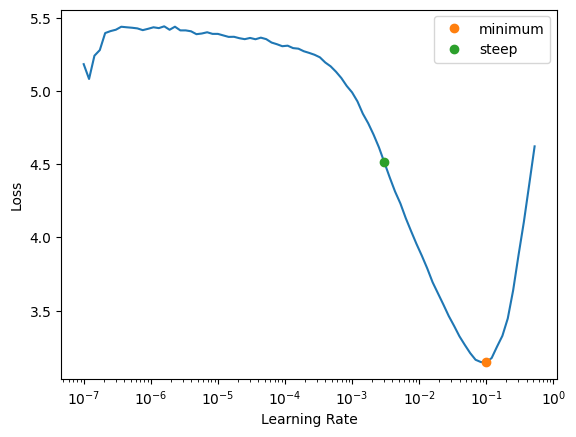

In [27]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [28]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 3.02e-03


In [29]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.351600,0.317441,0.098782,01:20


epoch,train_loss,valid_loss,error_rate,time
0,0.553927,0.379922,0.111637,01:32
1,0.342142,0.219459,0.069012,01:33


## Unfreezing and Transfer Learning

Will talk about how to fine-tune the weights of a pre-trained model.

The final linear layer is unlikely to be of any use for us when we are fine-tuning in a transfer learning setting, because it is specifically designed to classify the categories in the original pretraining dataset. So when we do transfer learning we remove it, throw it away, and replace it with a new linear layer with the correct number of outputs for our desired task (in this case, there would be 37 activations).

**Freezing**: When we want to leave certain layers alone (like in transfer learning) and only have the network change the weights in the final layers.

When we call `fine_tune`, fastai does two things:

1. Trains the randomly added layers for one epoch, with all other layers frozen.
2. Unfreezes all of the layers, and trains them all for the number of epochs requested.

Can also see the source code of any method by using the following syntax:

```python
learn.fine_tune??
```

Do `fine_tune` manually. First step is to train the randomly added layers for three epochs, using `fit_one_cycle`:

In [30]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.128517,0.410383,0.127199,01:30
1,0.547168,0.252474,0.081867,01:31
2,0.339887,0.228332,0.073072,01:29


In [31]:
# Unfreeze the model:

learn.unfreeze()

Run `lr_find` again, since we have more layers to train, and the weights that we have as of low have been trained for three epochs, which leans that our previously found learning rate isn't valid any more:

SuggestedLRs(valley=2.511886486900039e-05)

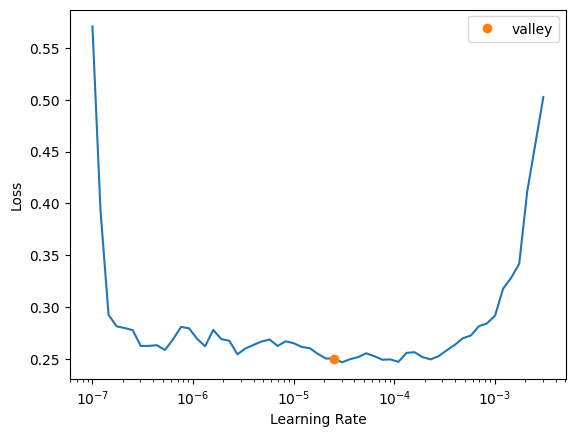

In [32]:
learn.lr_find()

Graph is a little different since we don't have the sharp descent that indiactes the model is training.

That's because the model has already been trained.

Want to take a point that is well before the sharp increase for our learning rate, like 1e-5:

In [33]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.255554,0.213976,0.073748,01:35
1,0.243810,0.207628,0.066306,01:33
2,0.222953,0.203239,0.071719,01:32
3,0.206503,0.204919,0.069012,01:34
4,0.186755,0.204999,0.067659,01:33
5,0.191306,0.203309,0.065629,01:34


**Potential issue**: The deepest layers of our pretrained model might not need as high a learning rate as the last ones. So we should probably use different learning rates for those. This is known as using *discriminative learning rates*.

## Discriminative Learning Rates

General idea: Use a lower learning rate for the early layers of the neural network, and a higher learning rate for the later layers (and especially the randomly added layers).

Can pass a `slice` object anywhere that a learning rate is expected. First value is the learning rate in the earliest layer of the network, and the second value is the learning rate in the final layer. Layers in between will have learning rates that are nultiplicatively equidistant throughout that range.

Example:

In [34]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.130829,0.294771,0.093369,01:30
1,0.530059,0.235663,0.072395,01:28
2,0.321346,0.202385,0.062923,01:30


epoch,train_loss,valid_loss,error_rate,time
0,0.260906,0.199518,0.064953,02:01
1,0.238125,0.191474,0.062923,01:49
2,0.239649,0.194405,0.060893,01:34
3,0.209334,0.187257,0.062246,01:37
4,0.183710,0.186589,0.058863,01:34
5,0.173659,0.184066,0.056834,01:33
6,0.160538,0.184120,0.058187,01:40
7,0.142724,0.187081,0.060893,01:54
8,0.134934,0.180449,0.054804,01:42
9,0.123954,0.175268,0.053451,01:31


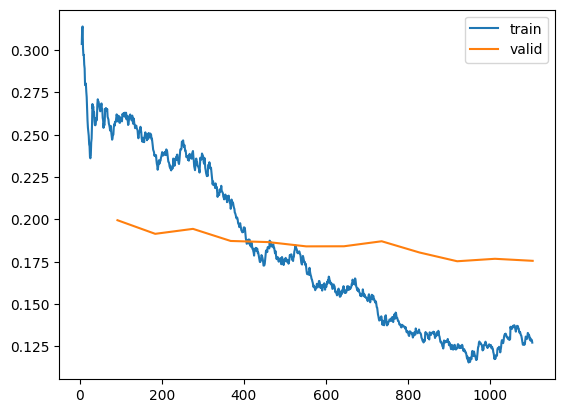

In [35]:
learn.recorder.plot_loss()

Training loss keeps getting better, but eventually the validation loss improvement slows and eventually gets worse, which indicates that the model is starting to overfit.

What matters here is your accuracy/chosen metrics, not the loss.

# Selecting the Number of Epochs

First step is to pick a number of epochs that you are fine waiting for. Then look at the training and validation loss plots, your metrics, and if they are still getting better even in your final epochs, then you haven't trained for too long.

Conversely, the metrics might be getting worse at the end of training. Remember that we're not just that we're looking for the validation loss to get worse, but the actual metrics. Validation loss will first get worse during training because the model is getting overconfident.

If you have overfit, you should retrain the model from scratch, and select a total number of epochs based on where the previous best results were found.

If you have the time to train for more epochs, might want to instead use that time to train more parameters (i.e. use a deeper architecture).

## Deeper Architectures

Generally, a model with more parameters can model your data more accurately.
  * There are a **lot** of caveats to this, but in general this is true.

In practice, architectures come in a small number of varients. A larger (more layers and parameters) will give a better training loss, but can suffern more from overfitting, because it has more parameters to overfit with.

A deeper model also requires more GPU RAM, so might need to lower the size of the batches to avoid an out-of-memory error. Can pass the batch size by creating your `DataLoaders` with `bs=blah`.

Deeper architectures also take a long time to train. Can speed this up with *mixed-precision training*. Just add `to_fp16()` after `Learner` creation (also need to import the module).

Don't know ahead of time what the best architecture is, so need to try training some.

Let's try ResNet-50 now with mixed precision:

In [2]:
from fastai.callback.fp16 import *

learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

NameError: ignored